#### NEED TO DO

1. train:val:test split. Not done here. Used all drugs to do training (since the data is few)
2. label should be one hot encoding and use BCELoss, here just use the original [1,2,3,4,5] and used MSELoss, need to be changed
3. Did not incorporate protein expression info. Could try simple multiplication on IC$_{50}$


In [1]:
! rm -R 'JAK_ML'
! git clone https://github.com/yingzibu/JAK_ML.git --quiet
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git --quiet
! pip install pubchempy --quiet
! pip install rdkit --quiet

rm: JAK_ML: No such file or directory
rm: a_inhibitor_design: No such file or directory


In [1]:
import pandas as pd
from tqdm import tqdm
import json 

drug_freq = pd.read_table('drug_reaction_freq.tsv')
drug_freq = drug_freq.iloc[:, :-1]
drug_smiles = pd.read_table('drug_smiles_ic50.tsv')
drug_smiles = drug_smiles.iloc[:, :-1]
with open("prot_tissue_levels.json") as f:
    prot_levels = json.load(f)
prot_levels

{'TSPAN6': {'adipose tissue': 0,
  'adrenal gland': 0,
  'appendix': 2,
  'bone marrow': 0,
  'breast': 3,
  'bronchus': 3,
  'caudate': 0,
  'cerebellum': 0,
  'cerebral cortex': 2,
  'cervix': 6,
  'colon': 2,
  'duodenum': 1,
  'endometrium 1': 3,
  'endometrium 2': 3,
  'epididymis': 2,
  'esophagus': 3,
  'fallopian tube': 3,
  'gallbladder': 2,
  'heart muscle': 0,
  'hippocampus': 0,
  'kidney': 2,
  'liver': 2,
  'lung': 1,
  'lymph node': 0,
  'nasopharynx': 3,
  'oral mucosa': 2,
  'ovary': 0,
  'pancreas': 3,
  'parathyroid gland': 2,
  'placenta': 4,
  'prostate': 2,
  'rectum': 2,
  'salivary gland': 2,
  'seminal vesicle': 3,
  'skeletal muscle': 0,
  'skin 1': 3,
  'skin 2': 2,
  'small intestine': 2,
  'smooth muscle': 0,
  'soft tissue 1': 0,
  'soft tissue 2': 0,
  'spleen': 0,
  'stomach 1': 2,
  'stomach 2': 2,
  'testis': 2,
  'thyroid gland': 2,
  'tonsil': 3,
  'urinary bladder': 3,
  'vagina': 3,
  'NaN': -100,
  'hypothalamus': -100,
  'endometrium': -100,
  'h

In [2]:
drug_smiles.columns
# drug_smiles['drug']

Index(['drug', 'SMILES', 'TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR',
       'CFH', 'FUCA2',
       ...
       'PRRC2B', 'CTAGE4', 'H2AC18', 'H2AC19', 'PPIAL4C', 'PPIAL4D', 'CTAGE8',
       'ENSG00000290147', 'HOMEZ', 'SOD2'],
      dtype='object', length=15006)

Incorporate the prot levels and IC50 values to just tisue concentration using multiplication and addition
(this may be illogical on an invalid assumption).

I am not sure if it makes sense 
to just multiply IC50 by expression level if a protein has different expression levels across tissues.

I also recalculated the protein expression levels- I noticed that the dataset
had different expression levels for different types of cells of the same tissue,
so I used a sum across the expression levels in the cells whenever this happened. I can attach the file
(in JSON format but I can also export it as TSV).

In [3]:
tissues = prot_levels["TSPAN6"].keys()
prots = prot_levels.keys()
start_ind = drug_smiles.columns.get_loc('TSPAN6')
end_ind = drug_smiles.columns.get_loc('SOD2')
drug_tissue = dict()

for ind in tqdm(drug_smiles.index, desc="Calculate tissue 'strength'", total=drug_smiles.shape[0]):
    tissue_levels = dict()
    for tissue in tissues:
        tissue_levels[tissue] = -100
    for prot_ind in range(start_ind, end_ind+1):
        prot = drug_smiles.columns[prot_ind]
        for tissue in tissues:
            level = prot_levels[prot][tissue]
            ic50 = drug_smiles[prot][ind]
            ans = -100
            if level >= 0:
                ans = level * ic50
            if ans != -100:
                if tissue_levels[tissue] == -100:
                    tissue_levels[tissue] = ans 
                else:
                    tissue_levels[tissue] += ans
    drug = drug_smiles['drug'][ind]
    drug_tissue[drug] = tissue_levels

with open("drug_tissue_conc.json", "w") as f:
    json.dump(drug_tissue, f, indent=4)

Calculate tissue 'strength':   1%|          | 9/759 [00:19<27:08,  2.17s/it]


KeyboardInterrupt: 

In [6]:
# If the above code was already ran, then just use this code
import json
f = open("drug_tissue_conc.json")
drug_tissue = json.load(f)
tissues = list(drug_tissue['alfentanil'].keys())
tissues

['adipose tissue',
 'adrenal gland',
 'appendix',
 'bone marrow',
 'breast',
 'bronchus',
 'caudate',
 'cerebellum',
 'cerebral cortex',
 'cervix',
 'colon',
 'duodenum',
 'endometrium 1',
 'endometrium 2',
 'epididymis',
 'esophagus',
 'fallopian tube',
 'gallbladder',
 'heart muscle',
 'hippocampus',
 'kidney',
 'liver',
 'lung',
 'lymph node',
 'nasopharynx',
 'oral mucosa',
 'ovary',
 'pancreas',
 'parathyroid gland',
 'placenta',
 'prostate',
 'rectum',
 'salivary gland',
 'seminal vesicle',
 'skeletal muscle',
 'skin 1',
 'skin 2',
 'small intestine',
 'smooth muscle',
 'soft tissue 1',
 'soft tissue 2',
 'spleen',
 'stomach 1',
 'stomach 2',
 'testis',
 'thyroid gland',
 'tonsil',
 'urinary bladder',
 'vagina',
 'NaN',
 'hypothalamus',
 'endometrium',
 'hair',
 'retina',
 'lactating breast',
 'skin',
 'thymus',
 'cartilage',
 'eye',
 'pituitary gland',
 'choroid plexus',
 'dorsal raphe',
 'substantia nigra',
 'sole of foot']

In [24]:
tissue_df = dict()
tissue_df['drug'] = drug_tissue.keys()
for tissue in tissues:
    tissue_df[tissue] = list()

for drug in drug_tissue:
    for tissue in drug_tissue[drug]:
        tissue_df[tissue].append(drug_tissue[drug][tissue])
tissue_df = pd.DataFrame.from_dict(tissue_df)
tissue_df = tissue_df.drop(columns=['NaN'])
tissue_df.to_csv('drug_tissue_conc.tsv', sep='\t', index=False)
tissue_df

,drug,adipose tissue,adrenal gland,appendix,bone marrow,breast,bronchus,caudate,cerebellum,cerebral cortex,...,lactating breast,skin,thymus,cartilage,eye,pituitary gland,choroid plexus,dorsal raphe,substantia nigra,sole of foot
0,alfentanil,37676.346622,92401.646475,148743.512605,68521.894656,159620.753807,113059.150268,105861.804748,199390.413653,213775.330821,...,110.328136,202.050750,644.644312,71.988383,251.756413,665.866735,49.939985,87.388055,43.969826,14.529084
1,telithromycin,27905.633777,68733.261935,111710.994134,50619.487115,117793.757969,82834.530376,78802.788146,150591.600443,159579.886973,...,110.478845,209.873276,433.994842,67.671166,282.707013,527.474737,41.319534,92.418443,62.511010,16.817363
2,simeprevir,30412.861233,74327.917130,121140.001853,55577.226433,128517.925715,91176.831669,85194.968413,161874.241416,172372.627623,...,138.438653,229.149533,532.179800,95.722804,340.042862,613.377880,42.449978,67.940117,44.831690,19.932617
3,pentamidine.isethionate,51246.591628,124407.783854,202894.077663,92512.442446,216304.831869,151660.886256,144641.880506,273145.946157,289064.810758,...,157.504479,307.941671,728.491714,152.392053,487.070249,965.252029,56.067854,175.615269,60.138426,14.307581
4,penicillamine,48388.288145,116718.667687,190648.658888,86814.041940,203487.166226,141535.921175,136506.759828,257155.675817,271576.376497,...,167.051922,273.294532,684.640600,134.378552,412.375527,856.394783,54.699396,170.283732,56.762997,15.124217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,rufinamide,49127.580665,118537.208462,193432.223874,87549.639921,206413.993729,143102.214467,138717.837588,263370.558671,276478.877905,...,135.831044,282.837629,637.839882,129.990364,449.584761,840.052249,53.226086,161.657796,68.337605,19.943464
755,tafluprost,59372.592203,145940.574013,236811.588438,107906.733297,251502.945618,177854.900364,167722.020846,314292.327099,335179.639858,...,235.652075,381.950586,869.594093,189.360628,528.520741,1173.433955,77.838357,199.262622,76.533422,20.764627
756,cabazitaxel,27140.121037,66297.628042,107459.030254,50000.203174,115261.709721,82391.819270,76513.032905,143410.700233,153937.779012,...,153.351370,154.662007,476.861863,63.493052,265.513955,543.071433,45.762447,65.658393,5.112104,16.291234
757,aclidinium.bromide,38054.901145,93800.312862,150599.196551,69827.957095,162250.676136,115883.955484,107642.576264,200929.472165,216197.693474,...,141.359597,203.454654,625.904541,98.290260,373.392626,803.661039,48.672781,112.897528,9.280093,15.053996


In [25]:
df_all = tissue_df.merge(drug_freq)
df_all.insert(1, column='SMILES', value=drug_smiles['SMILES'])
df_all

,drug,SMILES,adipose tissue,adrenal gland,appendix,bone marrow,breast,bronchus,caudate,cerebellum,...,tracheitis,blepharospasm,venous thrombosis,injection site bruising,actinic keratosis,seborrhoeic keratosis,malignant melanoma,mucous membrane disorder,aneurysm,cushing's syndrome
0,alfentanil,CCC(=O)N(C1=CC=CC=C1)C2(CCN(CC2)CCN3C(=O)N(N=N...,37676.346622,92401.646475,148743.512605,68521.894656,159620.753807,113059.150268,105861.804748,199390.413653,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
1,telithromycin,CC[C@@H]1[C@@]2([C@@H]([C@H](C(=O)[C@@H](C[C@@...,27905.633777,68733.261935,111710.994134,50619.487115,117793.757969,82834.530376,78802.788146,150591.600443,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
2,simeprevir,CC1=C(C=CC2=C1N=C(C=C2O[C@@H]3C[C@@H]4[C@@H](C...,30412.861233,74327.917130,121140.001853,55577.226433,128517.925715,91176.831669,85194.968413,161874.241416,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
3,pentamidine.isethionate,C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N,51246.591628,124407.783854,202894.077663,92512.442446,216304.831869,151660.886256,144641.880506,273145.946157,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
4,penicillamine,CC(C)([C@H](C(=O)O)N)S,48388.288145,116718.667687,190648.658888,86814.041940,203487.166226,141535.921175,136506.759828,257155.675817,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,rufinamide,C1=CC(=C(C(=C1)F)CN2C=C(N=N2)C(=O)N)F,49127.580665,118537.208462,193432.223874,87549.639921,206413.993729,143102.214467,138717.837588,263370.558671,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
755,tafluprost,CC(C)OC(=O)CCC/C=C\C[C@H]1[C@H](C[C@H]([C@@H]1...,59372.592203,145940.574013,236811.588438,107906.733297,251502.945618,177854.900364,167722.020846,314292.327099,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
756,cabazitaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...,27140.121037,66297.628042,107459.030254,50000.203174,115261.709721,82391.819270,76513.032905,143410.700233,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
757,aclidinium.bromide,C1C[N+]2(CCC1C(C2)OC(=O)C(C3=CC=CS3)(C4=CC=CS4...,38054.901145,93800.312862,150599.196551,69827.957095,162250.676136,115883.955484,107642.576264,200929.472165,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100


In [31]:
# Select a subset for testing
import numpy as np

test_rows = df_all.index >= 700
np.random.shuffle(test_rows)
test_df = df_all[test_rows]
test_df

,drug,SMILES,adipose tissue,adrenal gland,appendix,bone marrow,breast,bronchus,caudate,cerebellum,...,tracheitis,blepharospasm,venous thrombosis,injection site bruising,actinic keratosis,seborrhoeic keratosis,malignant melanoma,mucous membrane disorder,aneurysm,cushing's syndrome
22,cisatracurium,C[N@@+]1(CCC2=CC(=C(C=C2[C@H]1CC3=CC(=C(C=C3)O...,61499.062883,148249.942187,241531.562000,110711.272708,258819.598217,180810.747296,172755.354634,324235.141506,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
45,terbinafine,CC(C)(C)C#C/C=C/C[NH+](C)CC1=CC=CC2=CC=CC=C21,47762.826088,116594.905186,189367.354015,86577.816311,201185.716646,140965.473980,134746.812590,254272.216052,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
53,vernakalant,COC1=C(C=C(C=C1)CCO[C@@H]2CCCC[C@H]2N3CC[C@H](...,58978.299402,140835.438390,230555.779397,106040.934302,247607.263044,172051.887203,165636.371851,313131.640763,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
55,ipratropium.bromide,CC(C)[N+]1(C2CCC1CC(C2)OC(=O)C(CO)C3=CC=CC=C3)C,32395.255474,77364.439194,126282.908129,58279.403019,136128.873033,94766.790034,90626.655578,169870.478237,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
98,oxybutynin,CCN(CC)CC#CCOC(=O)C(C1CCCCC1)(C2=CC=CC=C2)O,43453.046833,104246.219944,170771.833487,77563.176826,182056.703866,126022.341971,121992.626590,230523.138402,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
101,moxifloxacin,COC1=C2C(=CC(=C1N3C[C@@H]4CCCN[C@@H]4C3)F)C(=O...,57271.538155,136948.193060,223513.960773,102716.271367,239924.619067,166132.595287,160998.014781,301798.351427,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
109,erythropoietin,C(C=O)[C@H](C=O)O,38650.787461,94705.482636,153253.792138,69778.766915,163207.983163,114290.166455,109071.985016,205149.095550,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
152,anastrozole,CC(C)(C#N)C1=CC(=CC(=C1)CN2C=NC=N2)C(C)(C)C#N,48137.204845,116905.550518,191013.953455,86627.809726,203210.498335,142674.768953,136176.073707,257169.671016,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
196,metolazone,CC1NC2=CC(=C(C=C2C(=O)N1C3=CC=CC=C3C)S(=O)(=O)...,57539.602842,140313.885480,227446.198575,104137.447366,242896.137101,170517.144458,162607.539422,306165.332449,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
198,metronidazole,CC1=NC=C(N1CCO)[N+](=O)[O-],53140.809514,129723.014907,211319.894114,95573.845631,223776.446737,156623.702974,149841.806570,284143.791489,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100


In [32]:
train_df = df_all[~test_rows]
train_df

val_rows = np.array([(x <= 100) for x in range(1, 701)])
np.random.shuffle(val_rows)
val_df = train_df[val_rows]

train_df = train_df[~val_rows]
val_df

,drug,SMILES,adipose tissue,adrenal gland,appendix,bone marrow,breast,bronchus,caudate,cerebellum,...,tracheitis,blepharospasm,venous thrombosis,injection site bruising,actinic keratosis,seborrhoeic keratosis,malignant melanoma,mucous membrane disorder,aneurysm,cushing's syndrome
0,alfentanil,CCC(=O)N(C1=CC=CC=C1)C2(CCN(CC2)CCN3C(=O)N(N=N...,37676.346622,92401.646475,148743.512605,68521.894656,159620.753807,113059.150268,105861.804748,199390.413653,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
7,retigabine,CCOC(=O)NC1=C(C=C(C=C1)NCC2=CC=C(C=C2)F)N,47675.150042,115083.473311,187762.239722,85273.159518,200081.942495,138735.431450,134821.349287,256603.004711,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
13,aminophylline,CN1C2=C(C(=O)N(C1=O)C)NC=N2.CN1C2=C(C(=O)N(C1=...,61008.315305,149889.919683,243193.562997,111702.739943,259562.673309,184438.648447,173465.152064,326310.876943,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
18,tiagabine,CC1=C(SC=C1)C(=CCCN2CCC[C@H](C2)C(=O)O)C3=C(C=...,52788.867635,129867.140988,209844.228600,95984.052890,223520.563562,158188.295465,148954.884127,280360.156112,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
25,rifabutin,C[C@H]1/C=C/C=C(\C(=O)NC2=C3C(=NC4(N3)CCN(CC4)...,42687.653161,102089.200718,168300.538596,77041.572628,178844.746542,124120.875786,119907.456942,226651.952874,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,testosterone,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)CCC4=CC...,52000.726285,128706.281243,207448.646566,95281.287769,221379.356104,157756.029160,147340.219695,276070.141905,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
718,tetrabenazine,CC(C)CC1CN2CCC3=CC(=C(C=C3C2CC1=O)OC)OC,59057.157198,142660.742227,232656.577712,105808.455321,248121.374917,172880.852276,165782.310758,312774.273331,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
724,busulfan,CS(=O)(=O)OCCCCOS(=O)(=O)C,42393.326779,101929.754053,166520.487378,76052.296634,178160.442384,123756.998791,119584.716926,226110.436969,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
730,podophyllotoxin,COC1=CC(=CC(=C1OC)OC)[C@H]2[C@@H]3[C@H](COC3=O...,37465.166994,92080.170293,148567.462372,67626.060877,157528.043248,110014.227381,105571.431980,200378.860275,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100


In [33]:
train_df

,drug,SMILES,adipose tissue,adrenal gland,appendix,bone marrow,breast,bronchus,caudate,cerebellum,...,tracheitis,blepharospasm,venous thrombosis,injection site bruising,actinic keratosis,seborrhoeic keratosis,malignant melanoma,mucous membrane disorder,aneurysm,cushing's syndrome
1,telithromycin,CC[C@@H]1[C@@]2([C@@H]([C@H](C(=O)[C@@H](C[C@@...,27905.633777,68733.261935,111710.994134,50619.487115,117793.757969,82834.530376,78802.788146,150591.600443,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
2,simeprevir,CC1=C(C=CC2=C1N=C(C=C2O[C@@H]3C[C@@H]4[C@@H](C...,30412.861233,74327.917130,121140.001853,55577.226433,128517.925715,91176.831669,85194.968413,161874.241416,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
3,pentamidine.isethionate,C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N,51246.591628,124407.783854,202894.077663,92512.442446,216304.831869,151660.886256,144641.880506,273145.946157,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
4,penicillamine,CC(C)([C@H](C(=O)O)N)S,48388.288145,116718.667687,190648.658888,86814.041940,203487.166226,141535.921175,136506.759828,257155.675817,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
5,lamivudine,C1[C@H](O[C@H](S1)CO)N2C=CC(=NC2=O)N,59943.770208,146667.296928,238333.823354,108801.013549,253506.430653,178478.205052,169392.635616,318923.955334,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,tranexamic.acid,C1CC(CCC1CN)C(=O)O,46233.452752,111969.785520,182906.191771,83252.664914,194924.004280,136355.545555,130627.293078,246102.182552,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
754,rufinamide,C1=CC(=C(C(=C1)F)CN2C=C(N=N2)C(=O)N)F,49127.580665,118537.208462,193432.223874,87549.639921,206413.993729,143102.214467,138717.837588,263370.558671,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
755,tafluprost,CC(C)OC(=O)CCC/C=C\C[C@H]1[C@H](C[C@H]([C@@H]1...,59372.592203,145940.574013,236811.588438,107906.733297,251502.945618,177854.900364,167722.020846,314292.327099,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
757,aclidinium.bromide,C1C[N+]2(CCC1C(C2)OC(=O)C(C3=CC=CS3)(C4=CC=CS4...,38054.901145,93800.312862,150599.196551,69827.957095,162250.676136,115883.955484,107642.576264,200929.472165,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100


In [34]:
from JAK_ML.ML_code.function import *
def process(df):
    MACCS_list = smile_list_to_MACCS(df['SMILES'].tolist())
    header = ['bit' + str(i) for i in range(167)]
    new_df = pd.DataFrame(MACCS_list, columns=header)
    new_df['SMILES'] = df['SMILES']
    new_df = new_df.merge(df)
    return new_df

train_df = process(train_df)
test_df = process(test_df)
val_df = process(val_df)
train_df

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,tracheitis,blepharospasm,venous thrombosis,injection site bruising,actinic keratosis,seborrhoeic keratosis,malignant melanoma,mucous membrane disorder,aneurysm,cushing's syndrome
0,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
1,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
2,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
3,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
4,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
473,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
474,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
475,0,0,0,0,0,0,0,0,0,0,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100


In [35]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pickle
import numpy as np

class Classifier(nn.Module):
    def __init__(self, dims):
        super(Classifier, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        self.dims = dims
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        # self.emb = nn.GRU(h_dims[-1], h_dims[-1])
        self.final = nn.Linear(h_dims[-1], out_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.final(x)
        return x

def onehot(k):
    def encode(label):
        y = torch.zeros(len(label), k+1)
        for i, j  in enumerate(label):
            if j.item() <= k and j.item() > 0:
                y[i][int(j.item())] = 1
            else:
                y[i][0] = 1
        return y
    return encode
# onehot(5)(ae)

class tox_dataset(Dataset):
    def __init__(self, df):
        self.len = len(df)
        self.df = df
        self.ic_start_ind = df.columns.get_loc("adipose tissue")
        self.ae_start_ind = df.columns.get_loc('asthenia')

    def __getitem__(self, idx):
        """
        OUTPUT
        :param fp: fingerprint, should be 167 dim
        :param ic: drug tissue concentration
        :param ae: adverse events
        """
        header = ['bit' + str(i) for i in range(167)]
        fp = self.df[header]
        fp = torch.tensor([float(b) for b in fp.iloc[idx]], dtype=torch.float32)
        ic = self.df.iloc[:, self.ic_start_ind:self.ae_start_ind]
        ic = torch.tensor(ic.values.astype(np.float32))[idx]
        ae = self.df.iloc[:, self.ae_start_ind:]
        ae = torch.tensor(ae.values.astype(np.float32))[idx]
        ae = onehot(5)(ae)
        return fp, ic, ae
    def __len__(self): return self.len


In [36]:
# dataset test, select first row
fp, ic, ae = tox_dataset(train_df)[0]
fp, ic, ae

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
         0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0.]),
 tensor([2.7906e+04, 6.8733e+04, 1.1171e+05, 5.0619e+04, 1.1779e+05, 8.2835e+04,
         7.8803e+04, 1.5059e+05, 1.5958e+05, 8.7647e+04, 1.6799e+05, 8.7917e+04,
         8.2734e+04, 7.6709e+04, 6.2939e+04, 5.6466e+04, 7.9174e+04, 7.3434e+0

In [37]:
# hidden dims of neural network are changeable,
# as long as its all integers
h_dims = [256*2, 256, 128]
##############################################


# BELOW IS NOT CHANGEABLE
in_dim = fp.shape[0] + ic.shape[0]
out_dim = ae.shape[0]*6

dims = [in_dim, h_dims, out_dim]
dims

[230, [512, 256, 128], 5964]

In [38]:
# batch_size is changeable
params = {'batch_size':16, 'shuffle':True,
          'drop_last':False, 'num_workers': 0}

train_loader = DataLoader(tox_dataset(train_df), **params)
val_loader = DataLoader(tox_dataset(val_df), **params)
test_loader = DataLoader(tox_dataset(test_df), **params)

In [47]:
model = Classifier(dims)
cuda = torch.cuda.is_available()
if cuda: model = model.cuda()

In [48]:
import torch.optim as optim
loss_function = nn.CrossEntropyLoss() # better use cross entropy, need onehot encoding

def custom_loss(pred, true):
    loss_list = []
    # print(f"pred shape: {pred.shape}")
    # print(f"true shape: {true.shape}")
    # pred should be 994*6 = 5964 length vector
    # true should be 994 by 6 vector
    for j in range(0, 994):
        start = j*6
        end = start+6
        preds = torch.index_select(pred, 0, torch.LongTensor([x for x in range(start, end)]))
        true_probs = true[j]
        loss = loss_function(preds, true_probs)
        loss_list.append(loss)
    total_loss = loss_list[0]
    for i in range(1, len(loss_list)):
        total_loss = total_loss + loss_list[i]
    return total_loss




# parameter changeable:
lr = 1e-3 # learning rate
wd = 1e-3 # weight decay
#######################

optimizer = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)

In [49]:
import matplotlib.pyplot as plt
def get_min(d:dict):
    min_key = next(iter(d))
    for key in d:
        if d[key] < d[min_key]: min_key = key
    return min_key, d[min_key]

def plot_loss(a:dict, b:dict):
    plt.plot(a.keys(), a.values())
    plt.plot(b.keys(), b.values())
    argmin, min = get_min(b)
    plt.plot(argmin, min, '*', label=f'min epoch: {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss during training/validation')
    plt.legend()
    plt.show()
    plt.close()

Validation at epoch 0: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


[Train] Cross Entropy loss: 162888.974
[Val] Cross Entropy Loss: 1750.270


Validation at epoch 1: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


[Train] Cross Entropy loss: 1733.549
[Val] Cross Entropy Loss: 1712.700


Validation at epoch 2: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


[Train] Cross Entropy loss: 1695.221
[Val] Cross Entropy Loss: 1672.504


Validation at epoch 3: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


[Train] Cross Entropy loss: 1657.978
[Val] Cross Entropy Loss: 1668.945


Validation at epoch 4: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


[Train] Cross Entropy loss: 1618.254
[Val] Cross Entropy Loss: 1592.869


Validation at epoch 5: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


[Train] Cross Entropy loss: 1581.379
[Val] Cross Entropy Loss: 1556.133


Validation at epoch 6: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


[Train] Cross Entropy loss: 1542.086
[Val] Cross Entropy Loss: 1578.938


Validation at epoch 7: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


[Train] Cross Entropy loss: 1514.025
[Val] Cross Entropy Loss: 1479.495


Validation at epoch 8: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


[Train] Cross Entropy loss: 1471.509
[Val] Cross Entropy Loss: 1438.689


Validation at epoch 9: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


[Train] Cross Entropy loss: 1428.576
[Val] Cross Entropy Loss: 1400.662


Validation at epoch 10: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]

[Train] Cross Entropy loss: 1412.571
[Val] Cross Entropy Loss: 1435.390


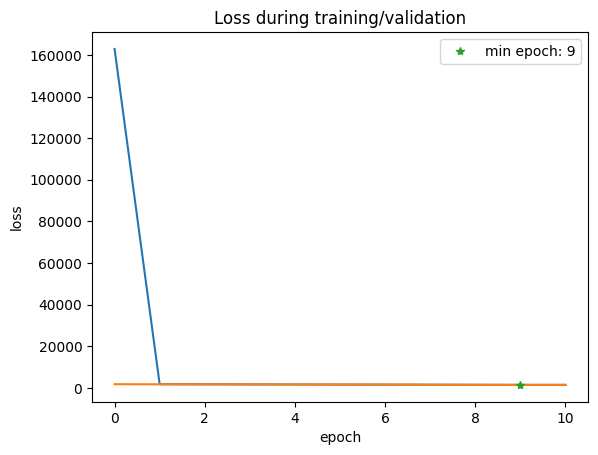

Validation at epoch 11: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


[Train] Cross Entropy loss: 1358.837
[Val] Cross Entropy Loss: 1340.918


Validation at epoch 12: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


[Train] Cross Entropy loss: 1320.557
[Val] Cross Entropy Loss: 1298.080


Validation at epoch 13: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


[Train] Cross Entropy loss: 1301.714
[Val] Cross Entropy Loss: 1257.899


Validation at epoch 14: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


[Train] Cross Entropy loss: 1268.308
[Val] Cross Entropy Loss: 1222.562


Validation at epoch 15: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


[Train] Cross Entropy loss: 1232.817
[Val] Cross Entropy Loss: 1189.556


Validation at epoch 16: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


[Train] Cross Entropy loss: 1206.197
[Val] Cross Entropy Loss: 1158.685


Validation at epoch 17: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


[Train] Cross Entropy loss: 1162.336
[Val] Cross Entropy Loss: 1240.907


Validation at epoch 18: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


[Train] Cross Entropy loss: 1123.524
[Val] Cross Entropy Loss: 1108.623


Validation at epoch 19: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


[Train] Cross Entropy loss: 1117.205
[Val] Cross Entropy Loss: 1084.876


Validation at epoch 20: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

[Train] Cross Entropy loss: 1083.457
[Val] Cross Entropy Loss: 1185.131


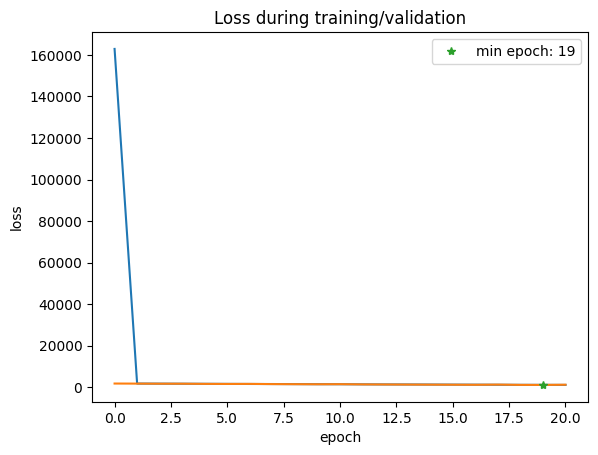

Validation at epoch 21: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


[Train] Cross Entropy loss: 1051.327
[Val] Cross Entropy Loss: 1107.550


Validation at epoch 22: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


[Train] Cross Entropy loss: 1026.102
[Val] Cross Entropy Loss: 1002.274


Validation at epoch 23: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


[Train] Cross Entropy loss: 1006.652
[Val] Cross Entropy Loss: 949.614


Validation at epoch 24: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


[Train] Cross Entropy loss: 973.781
[Val] Cross Entropy Loss: 923.197


Validation at epoch 25: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


[Train] Cross Entropy loss: 931.071
[Val] Cross Entropy Loss: 917.631


Validation at epoch 26: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


[Train] Cross Entropy loss: 932.919
[Val] Cross Entropy Loss: 893.656


Validation at epoch 27: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


[Train] Cross Entropy loss: 892.103
[Val] Cross Entropy Loss: 975.987


Validation at epoch 28: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


[Train] Cross Entropy loss: 866.211
[Val] Cross Entropy Loss: 825.884


Validation at epoch 29: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


[Train] Cross Entropy loss: 847.320
[Val] Cross Entropy Loss: 986.116


Validation at epoch 30: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]

[Train] Cross Entropy loss: 839.875
[Val] Cross Entropy Loss: 919.001


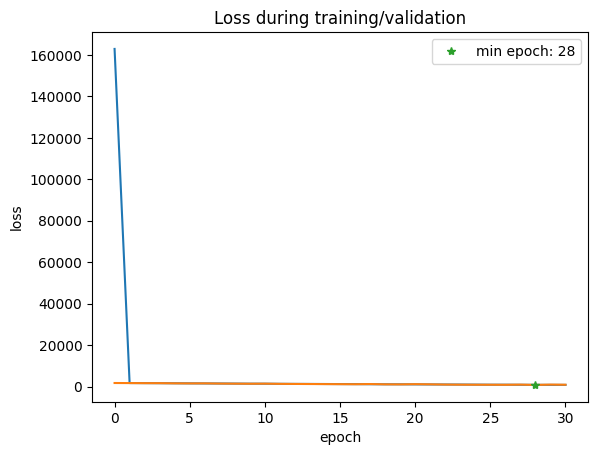

Validation at epoch 31: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


[Train] Cross Entropy loss: 789.580
[Val] Cross Entropy Loss: 791.193


Validation at epoch 32: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


[Train] Cross Entropy loss: 792.940
[Val] Cross Entropy Loss: 801.426


Validation at epoch 33: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


[Train] Cross Entropy loss: 776.286
[Val] Cross Entropy Loss: 783.070


Validation at epoch 34: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


[Train] Cross Entropy loss: 756.386
[Val] Cross Entropy Loss: 695.993


Validation at epoch 35: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


[Train] Cross Entropy loss: 758.539
[Val] Cross Entropy Loss: 679.753


Validation at epoch 36: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


[Train] Cross Entropy loss: 718.597
[Val] Cross Entropy Loss: 882.279


Validation at epoch 37: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


[Train] Cross Entropy loss: 694.372
[Val] Cross Entropy Loss: 670.602


Validation at epoch 38: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


[Train] Cross Entropy loss: 679.062
[Val] Cross Entropy Loss: 795.077


Validation at epoch 39: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


[Train] Cross Entropy loss: 688.694
[Val] Cross Entropy Loss: 611.075


Validation at epoch 40: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]

[Train] Cross Entropy loss: 667.649
[Val] Cross Entropy Loss: 604.426


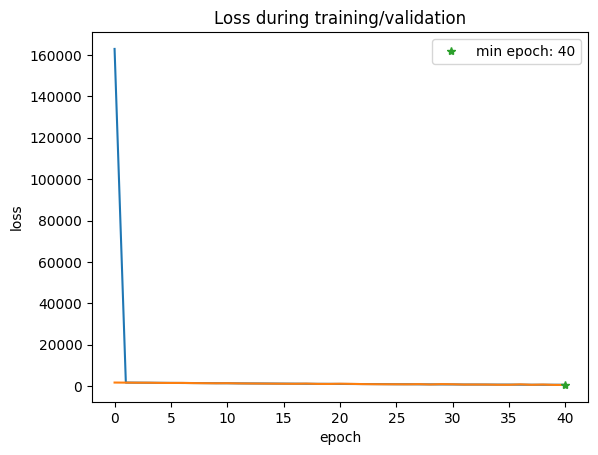

Validation at epoch 41: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


[Train] Cross Entropy loss: 656.357
[Val] Cross Entropy Loss: 621.085


Validation at epoch 42: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


[Train] Cross Entropy loss: 643.019
[Val] Cross Entropy Loss: 585.476


Validation at epoch 43: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


[Train] Cross Entropy loss: 631.367
[Val] Cross Entropy Loss: 594.055


Validation at epoch 44: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]

[Train] Cross Entropy loss: 601.754
[Val] Cross Entropy Loss: 901.817
loss increase 30% compared with min loss, early stop


In [50]:
import copy

epochs = 100
min_loss = 100000

loss_dict = {}
val_loss_dict = {}
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for i, (fp, ic, ae) in tqdm(enumerate(train_loader),
                                total=len(train_loader),
                            desc=f'Epoch {epoch}'):
        optimizer.zero_grad()
        if cuda: fp, ic, ae = fp.cuda(), ic.cuda(), ae.cuda()
        mask = torch.equal(ae, torch.zeros(5))
        # print(torch.cat((fp, ic), 1))
        output = model(torch.cat((fp, ic), 1))
        loss = custom_loss(output[~mask], ae[~mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0
    for i, (fp, ic, ae) in tqdm(enumerate(val_loader),
                                total=len(val_loader),
                                desc=f'Validation at epoch {epoch}'):
        mask = torch.equal(ae, torch.zeros(5))
        output = model(torch.cat((fp, ic), 1))
        loss = custom_loss(output[~mask], ae[~mask])
        val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f'[Train] Cross Entropy loss: {total_loss:.3f}')
    print(f'[Val] Cross Entropy Loss: {val_loss:.3f}')
    loss_dict[epoch] = total_loss
    val_loss_dict[epoch] = val_loss
    if val_loss < min_loss:
        model_max = copy.deepcopy(model)
        min_loss = val_loss
        torch.save(model.state_dict(), 'ckpt_v911.pt')

    # Employ early stop
    # training too long yet no loss decrease:  STOP
    argmin, min = get_min(val_loss_dict)
    if epoch - argmin > 10:
        print('no decrease after 10 epoch, early stop')
        break

    # training yet see loss increase too much: STOP
    if val_loss / min > 1.3:
        print('loss increase 30% compared with min loss, early stop')
        break

    if epoch % 10 == 0 and epoch != 0:
        plot_loss(loss_dict, val_loss_dict)


In [51]:
# Test on the testing set
test_loss = 0

model_max.eval()
for i, (fp, ic, ae) in tqdm(enumerate(test_loader), 
                            total=len(test_loader),
                            desc='Testing the final model'):
    mask = torch.equal(ae, torch.zeros(5))
    output = model_max(torch.cat((fp, ic), 1))
    loss = custom_loss(output[~mask], ae[~mask])
    test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Testing loss: {test_loss:.3f}')


Testing the final model: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]

Testing loss: 633.992
